## Model Type : Classification

## Use Case : Predict potential customers more likely to take a loan

One of the goals of our team is to understand customer behaviour and provide the right message at the right time to the right customer. To do this we try to understand how different customer segments behave and what they are likely to do next. This mandate requires a set of skills ranging from data cleaning, data manipulation, predictive modelling, data visualisation and the ability to articulate key messages to a Business audience.

o	The end goal is to create a predictive model allowing you to identify customers more likely to take on a loan

o	Emphasis will also be given to 
    	your ability to present the results and business benefits to engage a business audience
    	Data manipulation and cleaning
    	Application of your model to the test sample
    
o	We have kept an hold out sample, the quality of your work will be partially based on the hit rate you have been able to achieve based on your prediction 



## Importing sftp connections and mlflow generic packages 

In [1]:
import sys
sys.path.insert(0, '/home/jovyan')
from mlgeneric.mlsftp import *
from mlgeneric.classification import *
from sklearn.ensemble import RandomForestClassifier

<Figure size 960x640 with 0 Axes>

In [2]:
## setting the mlflow configurations and experiment name
ml_mlfow_init('http://mlflow:5000','Potential Loan seeker customer')

In [3]:
## checking the MLflow tracking server
mlflow.tracking.get_tracking_uri()

'http://mlflow:5000'

In [4]:
print(conda_env)

{'name': 'mlflow-env', 'channels': ['defaults', 'conda-forge'], 'dependencies': ['python=3.8.1', 'statsmodels=0.11.0', 'gunicorn=20.0.4', 'mlflow=1.6.0']}


## Downloading and reading the data

In [5]:
ml_pysftp('/ml/demo/data/experiment1/Loan_processed.csv')

/tmp/tmp3x8vifpk
Connection succesfully stablished ... 


In [6]:
df= ml_read_data("Loan_processed.csv")
df.head()

Age  Gender  Income_Group  Held_Loan_previously  ProductsCount  Avg_Amount  \
0   36 1.00000   10001-40000               1.00000        4.00000    58.00000   
1   24 0.00000  60001-100000               0.00000        4.00000    22.00000   
2   57 1.00000   10001-40000               0.00000        2.00000     0.00000   
3   21 1.00000   10001-40000               1.00000        1.00000    28.00000   
4   60     nan       100000+               0.00000        4.00000     0.00000   

   Num_Transactions  Last_TXN_Amount  Loan_Flag  
0           0.00000          0.00000          0  
1           5.00000         45.00000          0  
2          11.00000        890.00000          0  
3           4.00000        247.65000          0  
4           9.00000        220.27000          0

## About dataset:
Age , 
Gender ,
Demographics ,
Product Held in Bank ,
TXN Amount ,
Transactions out of Current Account ,
Previous Loan Holdings.

## Exploratory Data Analysis : 
In statistics, exploratory data analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. A statistical model can be used or not, but primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing task.

Few Examples are :
Line chart ,
Bar chart ,
Histogram , 
Scatterplot ,
Boxplot ,
Pareto chart ,
Pie chart ,
Area chart 
etc...


## Missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9983 entries, 0 to 9982
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   9983 non-null   int64  
 1   Gender                9982 non-null   float64
 2   Income_Group          9983 non-null   object 
 3   Held_Loan_previously  9967 non-null   float64
 4   ProductsCount         9973 non-null   float64
 5   Avg_Amount            9974 non-null   float64
 6   Num_Transactions      9973 non-null   float64
 7   Last_TXN_Amount       9974 non-null   float64
 8   Loan_Flag             9983 non-null   int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 702.1+ KB


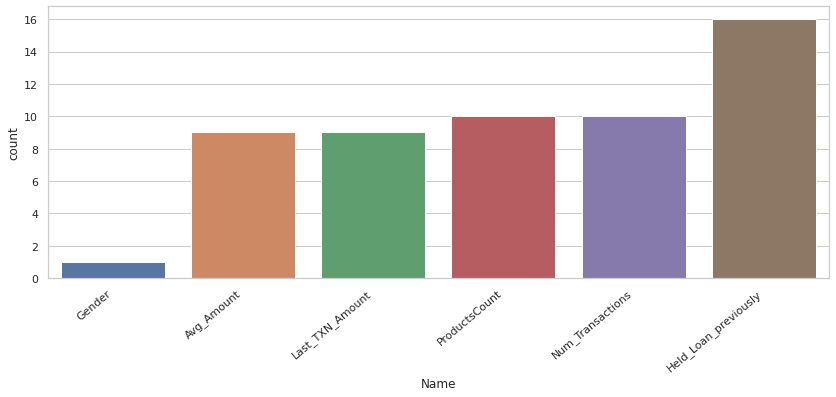

In [7]:
ml_missing_value_graph(df)
df.info()

## Class Imbalance

0    9773
1     210
Name: Loan_Flag, dtype: int64


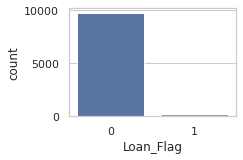

In [8]:
ml_target_class_imbalance(df,"Loan_Flag")

## Data Transformation and Training 

In [9]:
## Training of the model function
def train(df, target_col,split_ratio):
    
    temp = tempfile.mkdtemp()
    
    X = df.drop("Loan_Flag", axis=1)
    y = np.array(df["Loan_Flag"])
    
    np.random.seed(40)
    X_train, X_test, y_train, y_test = ml_train_test_targetCol_split(df, target_col, split_ratio)
    
    with mlflow.start_run():        
        
        categorical_features = X.dtypes == 'object'
        numeric_features = ~categorical_features
        
        #numeric_features = ["Age","ProductsCount", "Avg_Amount", "Num_Transactions","Last_TXN_Amount"]
        numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median',missing_values = np.nan)),
        ('scaler', StandardScaler())])

        #categorical_features = ["Gender","Income_Group" ,"Held_Loan_previously"]
        categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent', missing_values = np.nan)),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
        
        preprocessor = ColumnTransformer(
        transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])        
        
        # making the ML object
        model = RandomForestClassifier(n_estimators=100,bootstrap = True)
        
        
        estimator = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
        ])        
        
        # Fit on training data
        estimator.fit(X_train, y_train)
        
        # testing the model
        pred = estimator.predict(X_test)
        
        
        ##chekcing evaluation matrix
        (accuracy, f1_value, recall, precision, TN, FP, FN, TP)=ml_eval_matrix(y_test,pred)

        ## logging metrics
        mlflow.log_metric(key="Accuracy", value=float(accuracy))
        mlflow.log_metric(key="F1_value", value=float(f1_value))
        mlflow.log_metric(key="Recall",   value=float(recall))
        mlflow.log_metric(key="Precision",value=float(precision))
        mlflow.log_metric(key="TN", value=TN)
        mlflow.log_metric(key="FP", value=FP)
        mlflow.log_metric(key="FN", value=FN)
        mlflow.log_metric(key="TP", value=TP)
    
    
        ## logging artifacts and models
        mlflow.sklearn.log_model(estimator, "model")
        ml_confusion_matrix(y_test,pred).figure.savefig(os.path.join(temp, 'confusion_matrix.png'))
        ml_roc_curve(y_test,pred).savefig(os.path.join(temp, 'roc_curve.png'))
        mlflow.log_artifact(temp)
        shutil.rmtree(temp)
        
        ## calling and creating tags
        glantus_cep_input,glantus_cep_output=ml_create_tags(X,y)
        mlflow.set_tag("glantus.cep.input",json.dumps(glantus_cep_input))
        mlflow.set_tag("glantus.cep.output",json.dumps(glantus_cep_output))

        
        print(f'Run UUID: {mlflow.active_run().info.run_id}')

/home/jovyan/.conda/envs/jupy/lib/python3.8/site-packages/sklearn/pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


accuracy_score 0.9907852564102564
f1_score       0.7766990291262136
recall_score   0.6349206349206349
Precision      1.0

True Negative  2433
False Positive 0
False Negative 23
True Positive  40
AxesSubplot(0.125,0.125;0.62x0.755)


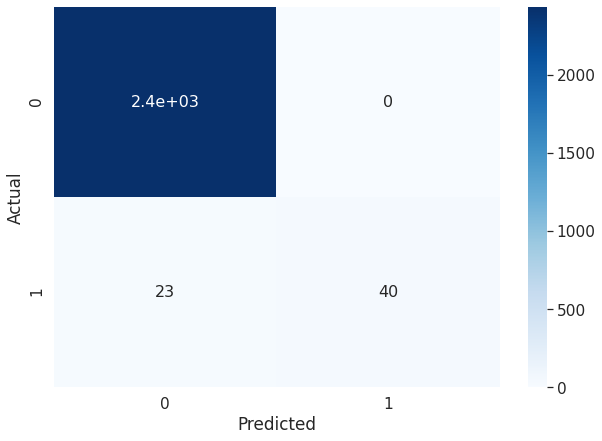

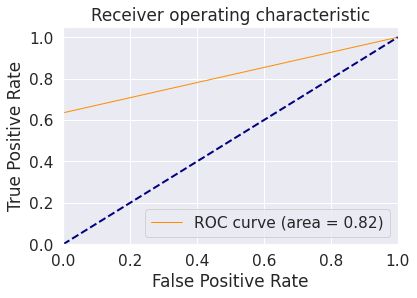

Run UUID: b275334d2ee646e4b3df54e904b29960


<Figure size 432x288 with 0 Axes>

In [10]:
train(df,"Loan_Flag", 0.25)